#**Building a model to work with 101 food classes**
We are going to build a model which will be trained on a larger dataset containing 101 classes.
We'll later fine-tune it.

## **Getting data**

In [1]:
import tensorflow as tf

In [2]:
tf.__version__ #it should be 2.9.0

'2.12.0'

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-07-13 13:55:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 64.233.170.128, 142.251.175.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  17.3MB/s    in 82s     

2023-07-13 13:57:02 (18.8 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
!unzip 101_food_classes_10_percent.zip

Streaming output truncated to the last 5000 lines.
  inflating: 101_food_classes_10_percent/train/beet_salad/2450020.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/550087.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/3132380.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/44885.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/1967147.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/1422905.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/1380319.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/1336726.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/2808614.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/66574.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/3537144.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/3165387.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/3391241.jpg  
  inflating: 101_f

In [5]:
train_dir='101_food_classes_10_percent/train'
test_dir ='101_food_classes_10_percent/test'

In [6]:
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                          label_mode='categorical',
                                                                          image_size=(224,224),
                                                                          batch_size=32)
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode='categorical',
                                                              image_size=(224,224),
                                                              batch_size=32)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [7]:
import os
for directory, folder, filename in os.walk('101_food_classes_10_percent'):
  print(f"There are {len(folder)} folders and {len(filename)} images in {directory}.")

There are 2 folders and 0 images in 101_food_classes_10_percent.
There are 101 folders and 0 images in 101_food_classes_10_percent/train.
There are 0 folders and 75 images in 101_food_classes_10_percent/train/scallops.
There are 0 folders and 75 images in 101_food_classes_10_percent/train/cup_cakes.
There are 0 folders and 75 images in 101_food_classes_10_percent/train/oysters.
There are 0 folders and 75 images in 101_food_classes_10_percent/train/edamame.
There are 0 folders and 75 images in 101_food_classes_10_percent/train/nachos.
There are 0 folders and 75 images in 101_food_classes_10_percent/train/garlic_bread.
There are 0 folders and 75 images in 101_food_classes_10_percent/train/spaghetti_bolognese.
There are 0 folders and 75 images in 101_food_classes_10_percent/train/tacos.
There are 0 folders and 75 images in 101_food_classes_10_percent/train/churros.
There are 0 folders and 75 images in 101_food_classes_10_percent/train/ramen.
There are 0 folders and 75 images in 101_food_c

## **Augmentation model**

In [8]:
from tensorflow.keras.layers.experimental import preprocessing

In [9]:
aug_model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224,224,3)),
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2)
],name='augmentation_model')

## **Modelling**

Getting [`helper_functions`](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py).

In [10]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-07-13 13:57:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-13 13:57:28 (107 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [11]:
from helper_functions import compare_historys,unzip_data, plot_loss_curves, make_confusion_matrix,create_tensorboard_callback

In [12]:
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False
inputs=tf.keras.layers.Input(shape=(224,224,3),name='input_layer')
x=aug_model(inputs)
x=base_model(x,training=False)
x=tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_2D')(x)
outputs=tf.keras.layers.Dense(101,activation='softmax',name='output_layer')(x)
model_1=tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [13]:
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [14]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('checkpoints/model_1/',
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    monitor='accuracy')

In [15]:
tensorboard_callback=create_tensorboard_callback('logs/','model_1')

Saving TensorBoard log files to: logs//model_1/20230713-135734


In [16]:

history_1=model_1.fit(train_data_10_percent,
            epochs=5,
            steps_per_epoch=len(train_data_10_percent),
            validation_data=test_data,
            validation_steps=int(0.15*len(test_data)),
            callbacks=[tensorboard_callback,model_checkpoint],
            )

Epoch 1/5
237/237 [==============================] - 120s 432ms/step - loss: 3.3782 - accuracy: 0.2730 - val_loss: 2.3274 - val_accuracy: 0.4619
Epoch 2/5
237/237 [==============================] - 79s 329ms/step - loss: 2.2205 - accuracy: 0.4961 - val_loss: 1.9026 - val_accuracy: 0.5342
Epoch 3/5
237/237 [==============================] - 69s 289ms/step - loss: 1.8562 - accuracy: 0.5604 - val_loss: 1.7454 - val_accuracy: 0.5556
Epoch 4/5
237/237 [==============================] - 62s 260ms/step - loss: 1.6368 - accuracy: 0.6032 - val_loss: 1.6626 - val_accuracy: 0.5699
Epoch 5/5
237/237 [==============================] - 61s 256ms/step - loss: 1.4863 - accuracy: 0.6379 - val_loss: 1.5964 - val_accuracy: 0.5784


In [17]:
model_1_score=model_1.evaluate(test_data)

790/790 [==============================] - 61s 77ms/step - loss: 1.5841 - accuracy: 0.5834


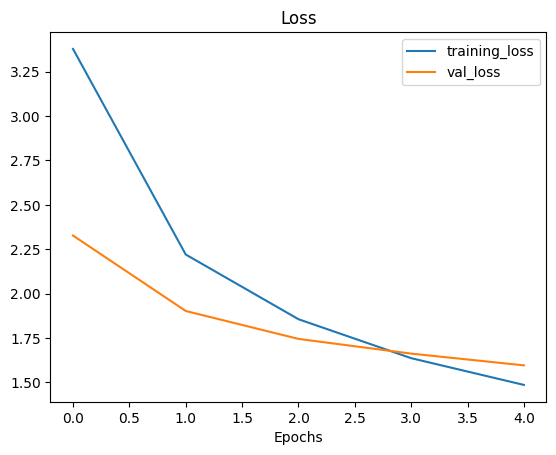

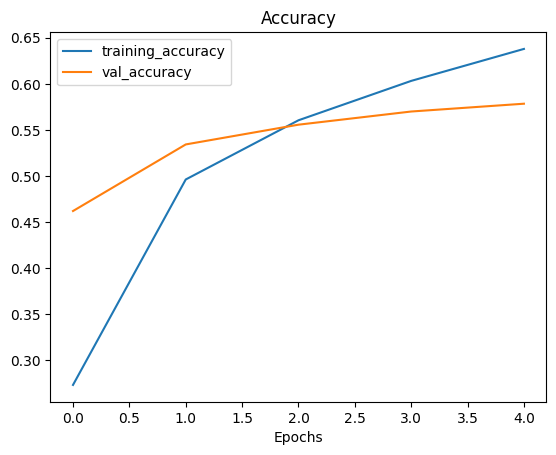

In [18]:
plot_loss_curves(history_1)

## **Fine-tuning last 5 layers**

In [19]:
base_model.trainable

False

In [20]:
model_1.trainable

True

In [21]:
for layer in model_1.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x784bb8725330> True
<keras.engine.sequential.Sequential object at 0x784bbd034880> True
<keras.engine.functional.Functional object at 0x784b0e4d6c20> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x784b0e599930> True
<keras.layers.core.dense.Dense object at 0x784b0e4ee3e0> True


In [22]:
for layer in model_1.layers[2].layers:
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x784b0edd87c0> False
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x784b0edd99f0> False
<keras.layers.preprocessing.normalization.Normalization object at 0x784bbd034910> False
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x784bbd271030> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x784b0edd8df0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x784b0eddab60> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x784b0edd9930> False
<keras.layers.core.activation.Activation object at 0x784b0e8e4f40> False
<keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x784b0e8e5810> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x784b0e8e7190> False
<keras.layers.core.activation.Activation object at 0x784b0e8e79a0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling

In [23]:
#unfreezing last 5 layers
base_model.trainable=True
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [24]:
for layer in base_model.layers:
  print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [25]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('checkpoints/model_2/',
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    monitor='accuracy')

In [ ]:
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics='accuracy')

history_2=model_1.fit(train_data_10_percent,
                      epochs=10,
                      steps_per_epoch=len(train_data_10_percent),
                      validation_data=test_data,
                      validation_steps=int(0.15*len(test_data)),
                      callbacks=[create_tensorboard_callback('logs/','model_2'), model_checkpoint],
                      initial_epoch=history_1.epoch[-1])

Saving TensorBoard log files to: logs//model_2/20230713-140553


Epoch 5/10
236/237 [============================>.] - ETA: 0s - loss: 1.2463 - accuracy: 0.6733

In [ ]:
model_2_score=model_1.evaluate(test_data)

In [ ]:
plot_loss_curves(history_2)

In [ ]:
compare_historys(history_1, history_2)

## **Making Predictions on test data**

In [ ]:
y_preds=model_1.predict(test_data)

In [ ]:
y_pred=[]
for i in y_preds:
  y_pred.append(i.argmax())

In [ ]:
y_pred[:10]

In [ ]:
y_labels=[]
for images, label in test_data.unbatch():
  y_labels.append(tf.argmax(label))

In [ ]:
y_labels[10]

In [ ]:
len(y_labels)

## **Evaluation of the fine-tuned model**

### **Confusion matrix**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
import seaborn as sns

In [ ]:
cm=confusion_matrix(y_labels,y_pred)

In [ ]:
plt.figure(figsize=(40,40))
sns.heatmap(cm,annot=True,cmap=plt.cm.Blues)
plt.xticks(ticks=range(len(test_data.class_names)),labels=test_data.class_names)
plt.yticks(ticks=range(len(test_data.class_names)),labels=test_data.class_names,rotation=0);


### **Classification report**

In [ ]:
cr=classification_report(y_labels,y_pred,output_dict=True)

In [ ]:
cr


In [ ]:
#ignore the TypeError in this cell. it does the job
f1_dict={}
class_names=test_data.class_names
for k, v in cr.items():
  if k=='accurcay':
    break
  else:
    f1_dict[class_names[int(k)]]=v['f1-score']

In [ ]:
f1_dict

#### **Visualizing the F1-scores to know where our model is performing the worst**

In [ ]:
import pandas as pd

In [ ]:
from matplotlib.pyplot import axis
df=pd.DataFrame({'class_names':list(f1_dict.keys()), 'f1_score':list(f1_dict.values())}).sort_values('f1_score',ascending=False)

In [ ]:
df

In [ ]:
fig, ax=plt.subplots(figsize=(10,25))
scores=ax.barh(range(len(df)), df['f1_score'] )
ax.set_yticks(ticks=range(len(df['f1_score'])), labels=class_names,)
ax.set_ylabel('Classes')
ax.set_xlabel('F1_score')
ax.set_title('F1-scores of all classes')
ax.invert_yaxis();

so its performing worst overall, it means that model is really overfitting because its performance on the train data is top notch

## **Visualizing the predictions on test images**

we'll define a function to process and load image so the model can predict over it

In [ ]:
def load_and_process(filepath, rescale=True):
  '''
  Reads the filepath and return a preprocessed image as per the requirements of the model.
  '''
  img=tf.io.read_file(filepath)
  img=tf.io.decode_image(img,channels=3)
  img=tf.image.resize(img, [224,224])
  print(img.shape)
  if rescale:
    return img
  else:
    img=img/255.
    return img

Now lets define a function to predict on the processed image and plot the predictions, that way we can tell if the prediction was right or wrong

In [ ]:
import random

In [ ]:
def plot_pred(model,path,class_name):
  '''
  picks a random images from the given path of the given class name. predicts on it and the plot the predictions.
  '''
  path=path+"/"+class_name
  rn=random.randint(0, len(os.listdir(path)))
  rn_images=os.listdir(path)
  path=f"{path}/{rn_images[rn]}"
  img=load_and_process(path)
  pred=model.predict(tf.expand_dims(img,axis=0))
  print(pred)
  pred=tf.argmax(pred)
  plt.figure(figsize=(10,10))
  img=plt.imread(img)
  plt.imshow(img)
  plt.title(f"True label:{class_name} and predicted label:{class_names[pred]}")


In [ ]:
img=load_and_process(filepath='/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg')
print(img)
pred_1=model_1.predict(img)


In [ ]:
plot_pred(model_1, '101_food_classes_10_percent/test', 'apple_pie')